In [1]:
%matplotlib notebook
import pandas as pd 
import numpy as np 
import tushare as ts 
import matplotlib.pyplot as plt

In [2]:
# Get the k-line data of Mao Tai, loading it into DataFrame
df = ts.get_k_data('600519', start='2000-01-01')
print(df.head())
df.to_csv('./maotai.csv', index=False)

         date   open  close   high    low     volume    code
0  2001-08-27  5.392  5.554  5.902  5.132  406318.00  600519
1  2001-08-28  5.467  5.759  5.781  5.407  129647.79  600519
2  2001-08-29  5.777  5.684  5.781  5.640   53252.75  600519
3  2001-08-30  5.668  5.796  5.860  5.624   48013.06  600519
4  2001-08-31  5.804  5.782  5.877  5.749   23231.48  600519


In [3]:
# upload the data from local file and adjust the date column to the date_range index
new_df = pd.read_csv('./maotai.csv', index_col='date', parse_dates=['date'])
new_df.head()

,open,close,high,low,volume,code
date,,,,,,
2001-08-27,5.392,5.554,5.902,5.132,406318.00,600519
2001-08-28,5.467,5.759,5.781,5.407,129647.79,600519
2001-08-29,5.777,5.684,5.781,5.640,53252.75,600519
2001-08-30,5.668,5.796,5.860,5.624,48013.06,600519
2001-08-31,5.804,5.782,5.877,5.749,23231.48,600519


In [4]:
# output the date on which the stock closes up more than 3% from the day's open
date_1 = new_df.loc[new_df['close'] > 1.03 * new_df['open']].index
# Any date on which the stock opens down more than 2% from the previous day's close
date_2 = new_df.loc[new_df['open'] < 0.98 * new_df['close'].shift(1)].index

### Strategy One ###
#### Buy one share of stock at beginning of each month after 2010, and sell all the stocks at the ending of each year ####

In [5]:
# get the last open price
price_last = new_df['open'][-1]
# only consider the date interval from 2010-01 to 2019-01
df_interval = new_df['2010-01':'2019-01']
# resample the data into monthly data, use the first data of each month because buying at the beginning of month
df_monthly = df_interval.resample('M').first()
# resample the data into yearly data, use the last data of each year because selling at the end of year, and drop the last one
df_yearly = df_interval.resample('Y').last()[:-1]
print(df_monthly, df_yearly)

               open    close     high      low    volume    code
date                                                            
2010-01-31  109.760  108.446  109.760  108.044  44304.88  600519
2010-02-28  107.769  107.776  108.216  106.576  29655.94  600519
2010-03-31  106.219  106.085  106.857  105.925  21734.74  600519
2010-04-30  101.324  102.141  102.422  101.311  23980.83  600519
2010-05-31   81.676   82.091   82.678   80.974  23975.16  600519
2010-06-30   84.075   84.637   85.166   83.278  23525.57  600519
2010-07-31   81.586   81.057   81.586   80.725   7449.69  600519
2010-08-31   89.296   92.465   93.567   89.296  42965.73  600519
2010-09-30  102.288  101.052  103.834  100.420  25589.00  600519
2010-10-31  108.858  111.776  113.045  108.858  31608.00  600519
2010-11-30  105.122  105.483  106.217  104.478  49658.00  600519
2010-12-31  130.759  130.372  133.980  128.839  38016.00  600519
2011-01-31  120.388  119.487  121.033  117.619  60462.00  600519
2011-02-28  114.656  116.

In [6]:
# Using a account to record the money
cost_money = 0
# recoding the number of share stocks, 100 shares per transaction
holds = 0
for year in range(2010, 2020):
    # Buying stock and the account will decrease
    cost_money -= df_monthly.loc[str(year)]['open'].sum() * 100
    # Buying stock and the number of holds will increase
    holds += len(df_monthly.loc[str(year)]['open']) * 100
    if year != 2019:
        # Selling stocks and the account will increase
        cost_money += df_yearly.loc[str(year)]['open'][0] * holds
        # After selling out stocks, the number of holds will be zero
        holds = 0
# in the last year, no selling and keep stocks to now
cost_money += holds * price_last
print(cost_money)

318697.69999999984


#### Double moving average strategy ####
If I begin from January 1, 2010, initial capital is 100000 yuan, gold fork buys as far as possible, dead fork sells completely
how much will it yield?

In [7]:
df_ma = new_df['2010-01':'2019-01']
df_ma_5 = df_ma['close'].rolling(5).mean() # 5 days moving average
df_ma_30 = df_ma['close'].rolling(30).mean() # 30 days moving average

<IPython.core.display.Javascript object>


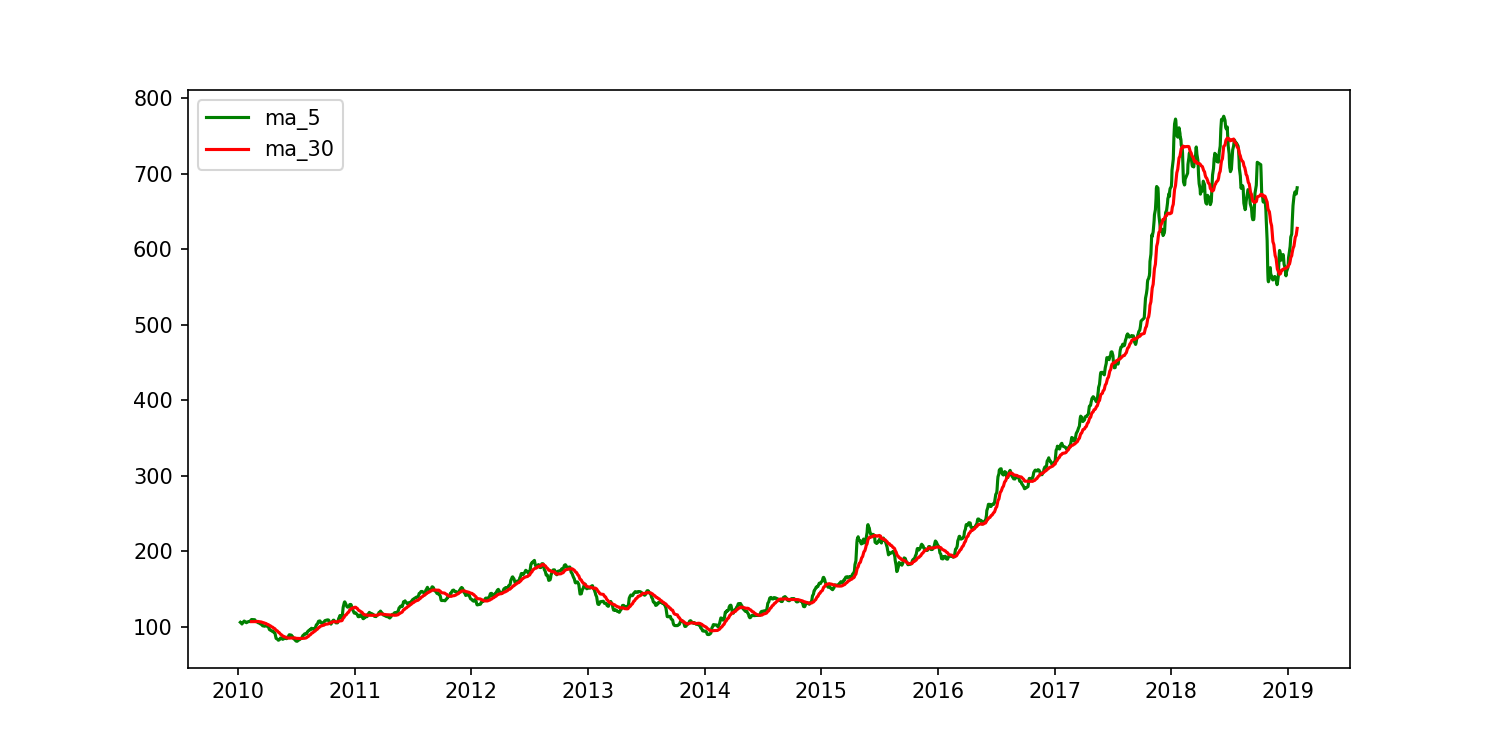

d:\language\python\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [8]:
fig = plt.figure(figsize = (10, 5))
plt.plot(df_ma_5, color = 'green', label = 'ma_5')
plt.plot(df_ma_30, color='red', label='ma_30')
plt.legend(loc='best')

In [9]:
s1_index = df_ma_5 < df_ma_30
s2_index = df_ma_5 > df_ma_30
# get the gold_cross point and dead_cross point
gold_cross = df_ma.loc[s2_index & s1_index.shift(1)].index
dead_cross = df_ma.loc[s1_index & s2_index.shift(1)].index
# set the new_series for gold_cross and dead cross, 1 and 0
series_gold = pd.Series(1, index = gold_cross)
series_dead = pd.Series(0, index = dead_cross)
# combine a new series and sort the date
series = pd.concat([series_gold, series_dead]).sort_index()

In [10]:
# simulate the real trade, buy tht stock on gold_cross date and sell it on dead_cross date
initial_money = 100000
money = initial_money
holds = 0

for i in range(len(series)):
    # get the price
    price = df_ma.loc[series.index[i], 'open']
    if series[i] == 1:
        # gold_cross point, buy in stock using the whole money at an integral multiples for 100s
        buy = money // (100 * price)
        holds += 100 * buy
        money -= buy * 100 * price
    else:
        # dead_cross point, sell all of stocks
        money += holds * price
        holds = 0

price = df_ma['open'][-1]
money += price * holds
print(money - initial_money)

930475.0999999996
